# Privacidade em Saúde
### MAC6988 - Cibersegurança (2025)
### Instituto de Matemática e Estatística, Google Brasil
Lucas Escobar\
Rodrigo Michelassi

### Aquisição dos dados
Para esse projeto, estaremos utilizando dados provenientes do DataSUS. Esses dados foram obtidos através de um [pacote R público](https://rfsaldanha.github.io/microdatasus/), em formato DBC, e convertidos para um arquivo `.csv`. Nossos dados são referentes a unidade federativa do Rio de Janeiro, entre janeiro e dezembro de 2024, na categoria SIH-RD (Sistema de Informações Hospitalares).

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_df = pd.read_csv('dados-datasus.csv')
data_df.head()

/var/folders/ty/w484s12s44x17p2vph_lydvm0000gn/T/ipykernel_14492/1822047910.py:1: DtypeWarning: Columns (3,53,62,63,69,82,84,87,88,96,97,98,99,100,101,102,103,105,106,107,108,109,110,111,112) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('dados-datasus.csv')


,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,TPDISEC8,TPDISEC9,munResStatus,munResTipo,munResNome,munResUf,munResLat,munResLon,munResAlt,munResArea
0,330000,2024,1,01,4.249872e+13,3324100808622,Principal,28960000,330187,2014-05-30,...,NaN,NaN,ATIVO,MUNIC,Iguaba Grande,Rio de Janeiro,-22.83906,-42.22212,7,51.945
1,330000,2024,1,03,NaN,3324101855790,Principal,24455710,330490,1941-05-14,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.82955,-43.03234,26,247.709
2,330000,2024,1,03,NaN,3324101855800,Principal,24417540,330490,1954-01-17,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.82955,-43.03234,26,247.709
3,330000,2024,1,03,NaN,3324101855811,Principal,24743630,330490,1984-11-16,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.82955,-43.03234,26,247.709
4,330000,2024,1,03,NaN,3324101855844,Principal,24475001,330490,1976-05-20,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.82955,-43.03234,26,247.709


### Análise e processamento dos dados
Os dados apresentados acima podem ser confusos, dado o nome das colunas. Para entender os dados tratados em cada um deles, é possível acessar a [documentação dos dados](https://datasus.saude.gov.br/transferencia-de-arquivos/#).

Para fazer o download da documentação, clique em _SIHSUS - Sistema de informações Hospitalares do SUS_ e, em seguida, _Documentação_.

Além dos conteúdos disponibilizados em aula sobre privacidade diferencial, que serão usados nesse projeto, uma [explicação prática](https://cloud.google.com/bigquery/docs/differential-privacy?hl=pt-br), desenvolvida pela Google, também foi disponibilizada.

> Na aula foi mostrado um dado de 2006 que aponta que 63% da população dos Estados Unidos pode ser identificada usando a data de aniversário, gênero e zip code. Logo, nossas análises devem conter informações relacionadas a esses dados.

In [3]:
# Remover colunas zeradas
columns_before = len(data_df.columns)

drop_cols = data_df.columns[(data_df == 0).all()]
data_df.drop(drop_cols, axis=1, inplace=True)

columns_after = len(data_df.columns)

print(f"Removidas {columns_before - columns_after} colunas zeradas.")

Removidas 23 colunas zeradas.


In [4]:
# Remover pacientes com mais de 100 anos (há incoerência nos dados)
data_df['NASC'] = pd.to_datetime(data_df['NASC'], errors='coerce')

data_df = data_df[data_df['NASC'].dt.year >= 1924]

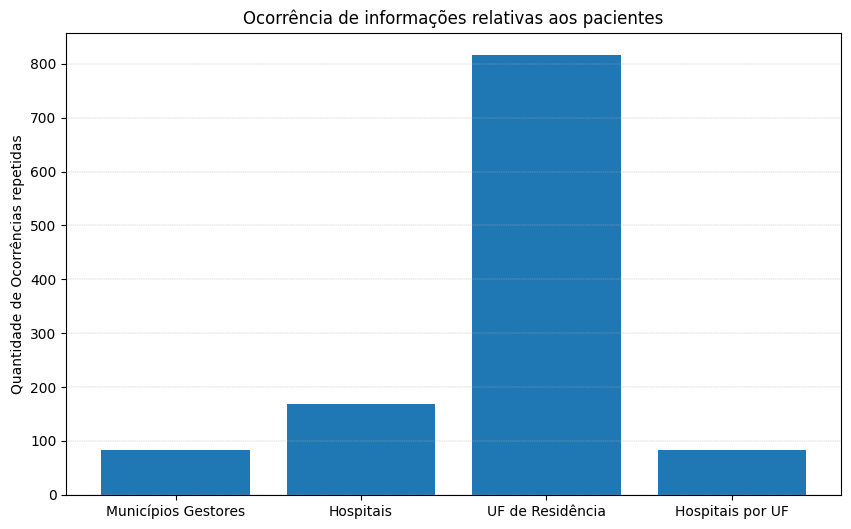

In [5]:
unique_uf = data_df['UF_ZI'].nunique()
unique_hospitals = data_df['CGC_HOSP'].nunique()
unique_residency_cities = data_df['MUNIC_RES'].nunique()
unique_hospital_cities = data_df['MUNIC_MOV'].nunique()

fig = plt.figure(figsize=(10,6))
plt.bar(['Municípios Gestores', 'Hospitais', 'UF de Residência', 'Hospitais por UF'], 
        [unique_uf, unique_hospitals, unique_residency_cities, unique_hospital_cities])
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência de informações relativas aos pacientes")
plt.ylabel("Quantidade de Ocorrências repetidas")
# plt.xticks(rotation=45)
plt.show()

Há cerca de 12.52 pacientes por CEP.


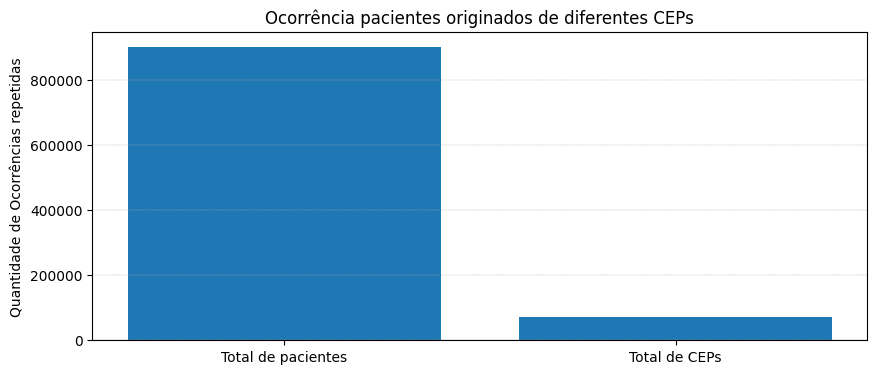

In [6]:
total_entries = data_df.shape[0]
unique_cep = data_df['CEP'].nunique()

print(f"Há cerca de {(total_entries / unique_cep):.2f} pacientes por CEP.")

fig = plt.figure(figsize=(10,4))
plt.bar(['Total de pacientes', 'Total de CEPs'], 
        [total_entries, unique_cep])
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes originados de diferentes CEPs")
plt.ylabel("Quantidade de Ocorrências repetidas")
# plt.xticks(rotation=45)
plt.show()

In [7]:
'''
Função:
agrupar duas listas por grupos 
de tamanho block_size.

values: lista com os índices
occurrencies: lista com os valores de cada índice
block_size: tamanho do bloco que será agrupado
'''
def group_lists(values, occurrencies, block_size=10):
    labels_list = []
    occurrencies_list = []
    
    for i in range(0, len(values), block_size):
        values_block = values[i:i + block_size]
        occurr_block = occurrencies[i:i + block_size]
        
        label = f"{values_block[0]}–{values_block[-1]}"
        total = sum(occurr_block)
        
        labels_list.append(label)
        occurrencies_list.append(total)
        
    return labels_list, occurrencies_list

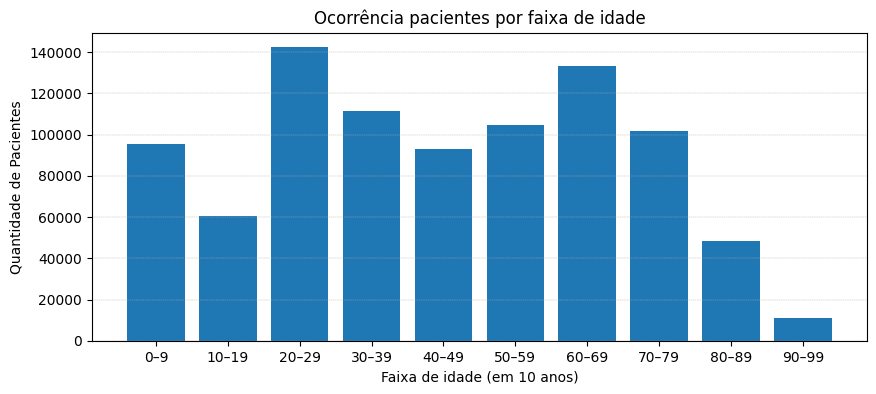

In [12]:
age_occurrencies = data_df['IDADE'].value_counts().sort_index()

age_list = age_occurrencies.index.tolist()
age_occurr_list = age_occurrencies.values.tolist()

age_blocks, age_occur_blocks = group_lists(age_list, age_occurr_list, 10)

fig = plt.figure(figsize=(10,4))
plt.bar(age_blocks, age_occur_blocks)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por faixa de idade")
plt.xlabel("Faixa de idade (em 10 anos)")
plt.ylabel("Quantidade de Pacientes")
# plt.xticks(rotation=45)
plt.show()

> Parece que a idade dos pacientes não é um fator de fácil identificação, pelo grande volume de pacientes no dataset. Todavia, ainda vale a pena explorar mais esses dados. Note há menos pacientes mais velhos em relação a pacientes numa faixa média de idade, porém o que isso implica? Talvez só existam menos pessoas de idades mais avançadas (80-99 anos, por exemplo).

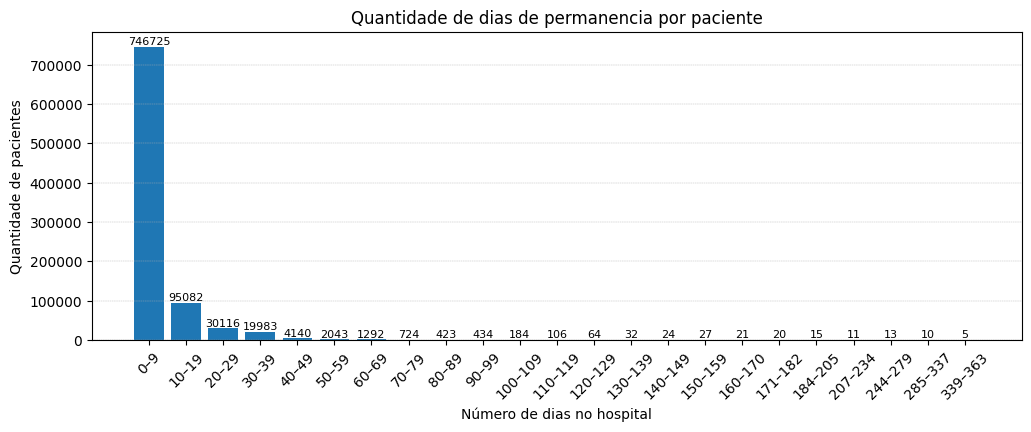

In [9]:
# como melhorar a visualização desse gráfico?
days_occurrencies = data_df['DIAS_PERM'].value_counts().sort_index()
# usar data_df['QT_DIARIAS'] dá um valor semelhante, esse deve ter pacientes que tiveram alta antes do previsto!

days_list = days_occurrencies.index.tolist()
days_occurr_list = days_occurrencies.values.tolist()

days_blocks, days_occur_blocks = group_lists(days_list, days_occurr_list, 10)

fig = plt.figure(figsize=(12,4))
bars = plt.bar(days_blocks, days_occur_blocks)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Quantidade de dias de permanencia por paciente")
plt.xlabel("Número de dias no hospital")
plt.ylabel("Quantidade de pacientes")
plt.xticks(rotation=45)
plt.show()

> Esse é um gráfico muito importante para se observar. Note que, conforme o número de dias de permanência no hospital vai crescendo, a quantidade de pacientes diminui drasticamente. Dessa forma, é fácil associar um paciente ao seu tempo de permanência, causando uma quebra em sua privacidade.

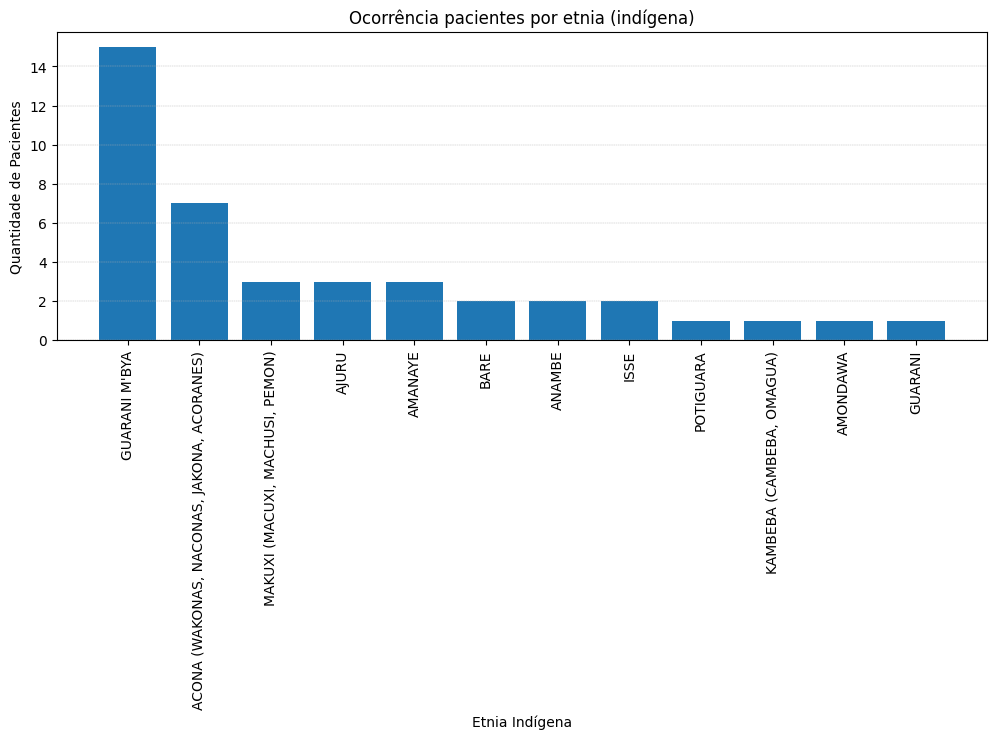

In [10]:
ethnicity_occurrencies = data_df['ETNIA'].value_counts()

ethnicity_list = ethnicity_occurrencies.index.tolist()[2:len(ethnicity_occurrencies)-1]
ethnicity_occurr_list = ethnicity_occurrencies.values.tolist()[2:len(ethnicity_occurrencies)-1]

fig = plt.figure(figsize=(12,4))
plt.bar(ethnicity_list, ethnicity_occurr_list)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por etnia (indígena)")
plt.xlabel("Etnia Indígena")
plt.ylabel("Quantidade de Pacientes")
plt.xticks(rotation=90)
plt.show()

> A raça/cor de uma pessoa pode ser um tipo de dado cuja divulgação seja sensível, porém, ao filtrarmos apenas pelos pacientes de acordo com suas etnias (indígenas), vemos que os pacientes são pouco diversos, tornando fácil a identificação (ex: tome pacientes Guarani. Há apenas um desses na lista, o que facilita sua identificação).

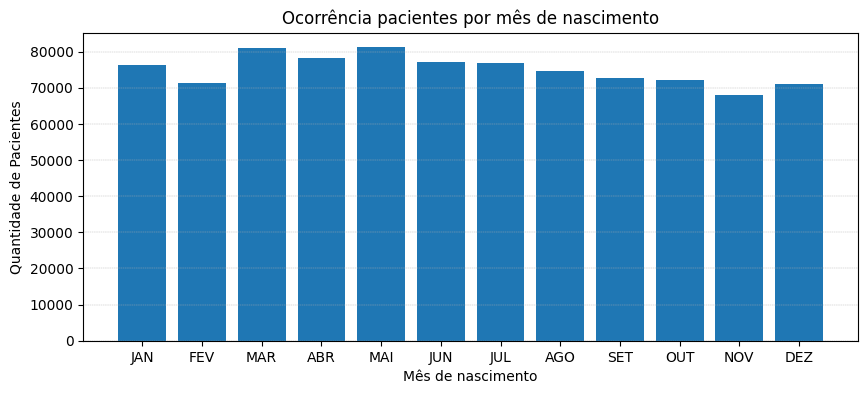

In [24]:
month_list = ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']

birth_occurrencies = data_df['NASC'].dt.month.value_counts().sort_index()

birth_month_occurrencias = birth_occurrencies.values.tolist()

fig = plt.figure(figsize=(10,4))
plt.bar(month_list, birth_month_occurrencias)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por mês de nascimento")
plt.xlabel("Mês de nascimento")
plt.ylabel("Quantidade de Pacientes")
plt.show()

> Parece que não há um problema muito grande relacionado ao mês de nascimento dos pacientes. O problema maior é relacionado ao ano, que já foi explorado no gráfico de idade, e será representado a seguir novamente.

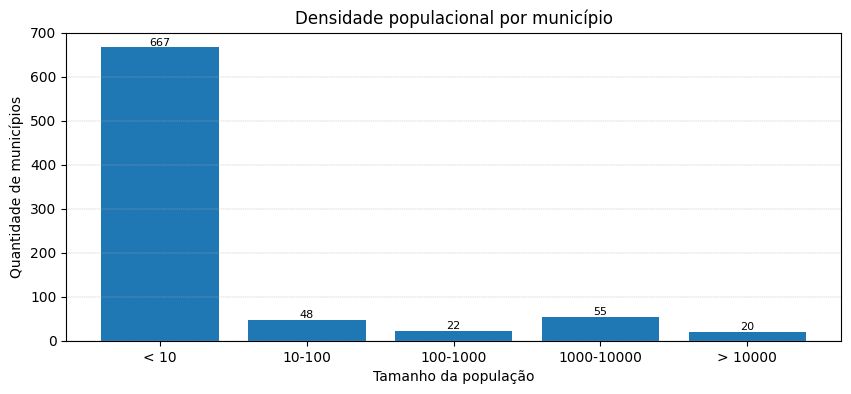

In [50]:
uf_occurrencies = data_df['MUNIC_RES'].value_counts().sort_values()

uf_occurr_list = uf_occurrencies.values.tolist()

population_density = ['< 10', '10-100', '100-1000', '1000-10000', '> 10000']
population_count = [0, 0, 0, 0, 0]

for item in uf_occurr_list:
    if item < 10:
        population_count[0] += 1
    if item > 10 and item <= 100:
        population_count[1] += 1
    if item > 100 and item <= 1000:
        population_count[2] += 1
    if item > 1000 and item <= 10000:
        population_count[3] += 1
    if item > 10000:
        population_count[4] += 1

fig = plt.figure(figsize=(10,4))
bars = plt.bar(population_density, population_count)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Densidade populacional por município")
plt.xlabel("Tamanho da população")
plt.ylabel("Quantidade de municípios")
plt.show()

> Aqui, há uma observação importante. Veja que há 812 municípios sendo analisados, mas 667 deles possui menos de 10 pacientes. Se analisarmos mais profundamente, vemos que mais de 300 municípios apresenta apenas um paciente. 
>
> Esse representa um problema fortíssimo de privacidade que podemos tentar resolver, mas por esse número ser proporcionalmente alto, a chance de sacrificarmos qualidade dos dados deve ser bem alta também.

Há um total de 90 CEPs diferentes no formato XX*. Nosso gráfico ilustra 8 prefixos diferentes.


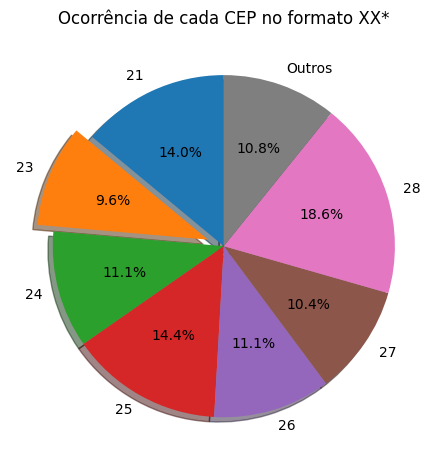

In [ ]:
'''
O CEP é organizado da seguinte forma:

X0000-000: Região
0X000-000: Sub-região
00X00-000: Setor
000X0-000: Subsetor
0000X-000: Divisor de subsetor
00000-XXX: Sufixo de distribuição

Iremos manter os CEPs agrupados até Setor
'''

cep_df = data_df['CEP'].astype(str).str[:2]

cep_occurrencies = cep_df.value_counts().sort_index()

cep_list = cep_occurrencies.index.tolist()
cep_occurr_list = cep_occurrencies.values.tolist()

total = sum(cep_occurr_list)

# Filtra os que têm >= 10% do total e agrupa o resto em "Outros"
cep_filtrados = []
valores_filtrados = []
outros_valor = 0

for cep, valor in zip(cep_list, cep_occurr_list):
    percentual = 100 * valor / total
    if percentual >= 6:
        cep_filtrados.append(cep)
        valores_filtrados.append(valor)
    else:
        outros_valor += valor

if outros_valor > 0:
    cep_filtrados.append("Outros")
    valores_filtrados.append(outros_valor)

print(f"Há um total de {len(cep_list)} CEPs diferentes no formato XX*. Nosso gráfico ilustra {len(cep_filtrados)-1} prefixos diferentes.")


explode = [0] * len(cep_filtrados)
explode[1] = 0.1

# Plot do gráfico
fig, ax = plt.subplots()
ax.pie(
    valores_filtrados,
    explode=explode,
    labels=cep_filtrados,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
plt.title("Ocorrência de cada CEP no formato XX*")
plt.tight_layout()
plt.show()


> Nesse gráfico, observamos que boa parte das pessoas vem de CEPs com o mesmo prefixo XX*. Note 10.8% das pessoas moram em CEPs listados em "outros", porém há mais de 80 CEPs registrados dessa forma. Isso se fixarmos o CEP apenas pelos dois primeiros dígitos (Região e Sub-região). Logo, a especificidade desse dado é gigante, e deve ser abordado na nossa análise de privacidade. 

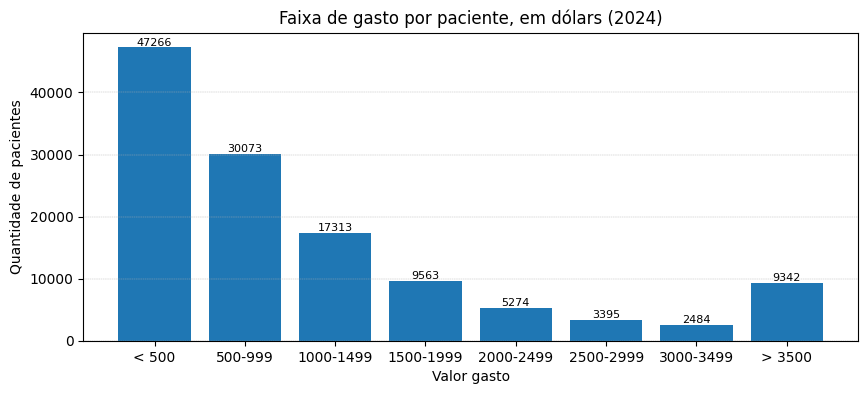

In [121]:
valueSpent_df = data_df['US_TOT']

valueSpentList = valueSpent_df.value_counts().sort_values()

values_list = [0] * 8
values_labels = ['< 500', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3499', '> 3500']

for value in valueSpentList.index.tolist():
    if value < 500:
        values_list[0] += 1
    if value >= 500 and value < 1000:
        values_list[1] += 1
    if value >= 1000 and value < 1500:
        values_list[2] += 1
    if value >= 1500 and value < 2000:
        values_list[3] += 1
    if value >= 2000 and value < 2500:
        values_list[4] += 1
    if value >= 2500 and value < 3000:
        values_list[5] += 1
    if value >= 3000 and value < 3500:
        values_list[6] += 1
    if value >= 3500:
        values_list[7] += 1
    
fig = plt.figure(figsize=(10,4))
bars = plt.bar(values_labels, values_list)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Faixa de gasto por paciente, em dólars (2024)")
plt.xlabel("Valor gasto")
plt.ylabel("Quantidade de pacientes")
plt.show()

> Esse dado é extremamente sensível, pois pode ligar pacientes a renda que tiveram disponível para gastar em serviços médicos. O maior gasto foi na casa de 3800. Como podemos gerar mais privacidade em relação a isso?

Nos dados, podemos também analisar o país de origem de cada paciente, no campo `data_df['NACIONAL']`. Todavia, esse campo está mal definido, alguns países tem seu nome escrito, outros em o código no formato `0XX` e outros no formato `XX`. 

Uma forma de corrigir isso seria acessando a [API de documentação dos países do IBGE](https://servicodados.ibge.gov.br/api/docs/paises), mas foge do escopo desse projeto. Note que, mesmo assim, uma análise muito mais cuidadosa dos dados seria necessária, dado que o nome de alguns países pode ter sido escrito errado, ou até mesmo de maneiras diferentes (por exemplo, variando letras maiúsculas), gerando mais de uma entrada na nossa tabela.

Assim, a princípio, se torna uma decisão de projeto não trabalhar com esses dados.

### Aplicando técnicas de privacidade